### Importing the theoretical $D_{l}$ obtained with CAMB (Lewis et. al. 2006)

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from input_camb import *
import healpy as hp

In [2]:
Dl

array([   0.        ,    0.        , 1028.01454306, ...,   66.35034063,
         66.2225099 ,   66.09623955])

In [7]:
ls=np.arange((Dl.shape[0]))

In [8]:
lmax = 2500
nside=2048
mapa_cl = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(1/60), new= True)

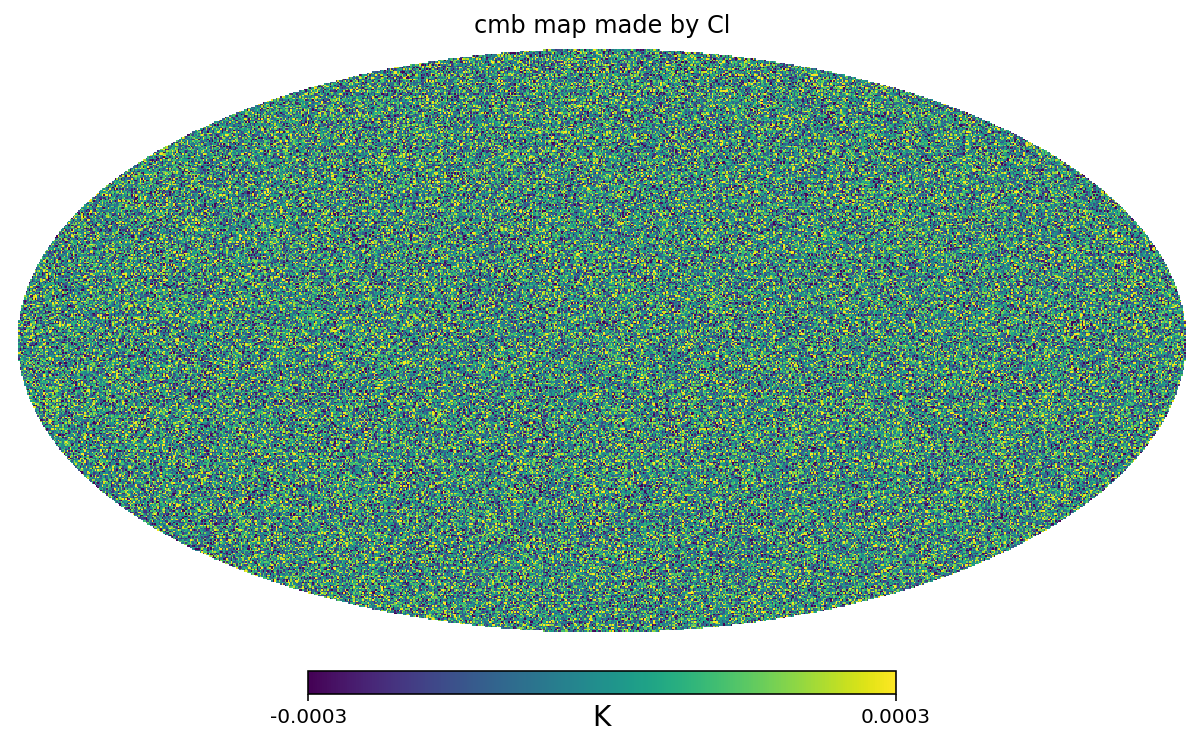

In [9]:
hp.mollview(mapa_cl*(1e-8), title = 'cmb map made by Cl', unit = 'K', min=-3e-4, max=3e-4)

In [10]:
cmb_map=np.save('mapa_cl_1', mapa_cl)

In [11]:
# ells
Cls=hp.anafast(mapa_cl, lmax=2551)
el=np.arange(len(Cls))


In [20]:
Cls.shape

(2552,)

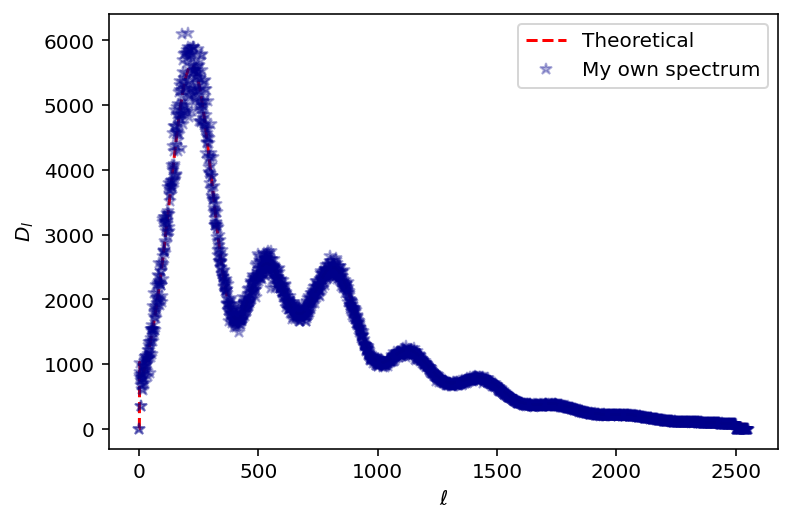

In [12]:
plt.plot(ls,Dl,'--',  color= 'r', label='Theoretical')
plt.plot(el,Cls, '*', alpha = 0.3, color = 'darkblue', label='My own spectrum')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_l$')
plt.legend()

In [13]:

np.savetxt('Cls',Cls)

Experimental errors

In [14]:
from IPython.display import display, Math
display(Math(r'\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}}} \cdot C_{\ell}'))

<IPython.core.display.Math object>

In this subsection, I am going to compute the errors of pseudo \(C_\ell\). To compute the errors for the pseudo-power spectrum, you can estimate them using a simple approximation. One of the most straightforward methods is to assume that the errors are dominated by cosmic variance and noise, which gives:

$$\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}} \cdot C_{\ell}}$$

Where $C_{\ell}$ are my pseudo power spectrum,
$f_{sky}=1$ is fraction of our sky for analysis.

In [15]:
Cl_err = np.sqrt(2 / (2*el + 1))*Cls

In [16]:
sigma=np.savetxt('sigma',Cl_err)

## MCMC with Cobaya (Lewis  & Torrado 2021)

In [18]:
from cobaya.likelihood import Likelihood
import os

I establish the Likelihood 

In [48]:
from cobaya.likelihood import Likelihood
import numpy as np

class MyLikelihood(Likelihood):
    
    def initialize(self):
        """
        Prepare any computation, importing necessary code, files, etc.
        Here, we load the Cls data.
        """
        # Load your data file, for example, experimental Cls
        self.data = np.loadtxt("Cls")  # Replace "Cls.txt" with your actual file
        
        # If you have associated errors, load them similarly (uncomment below if needed)
        # self.errors = np.loadtxt("sigma.txt")
    
    def get_requirements(self):
        """
        Return dictionary specifying quantities calculated by a theory code.
        Here, we request C_l^{tt} (temperature) up to lmax = 2552.
        """
        return {'Cl': {'tt': 2554}}  # You can request other spectra like 'ee', 'te' if needed.
    
    def logp(self, **params_values):
        """
        Compute the log-likelihood given a set of parameter values.
        """
        # Get the theoretical Cls from the theory code (e.g., CAMB or CLASS)
        cls = self.provider.get_Cl(ell_factor=True)

        # Calculate chi-squared: sum of squared differences between data and theory Cls
        chi2 = np.sum((self.data - cls['tt'][2:]) ** 2)  # Skipping ell=0,1 as usual

        # Return the log-likelihood (-0.5 * chi2)
        return -0.5 * chi2

    
        

Sampling the parameters

The base set of cosmological parameters we sample over are $\Omega_b h^{2}$ and $\Omega_c h^{2}$, the physical barion density and the CDM density
to critical density of universe, $h=H_0/(100 Km s^{-1} Mpc^{-1})$.

In [66]:
info_like = {
    "likelihood": {
        "My_custom_likelihood": MyLikelihood
    },
    # Parameters
    "params": {
        "ombh2": {
            "prior": {"min": 0.010, "max": 0.035}, 
            "ref": {
                "dist": "norm",
                "loc": 0.0221,
                "scale": 0.001
            },
            "latex": r"\Omega_b h^{2}"
        },
        "omch2": {
            "prior": {"min": 0.1, "max": 0.2}, 
            "ref": {
                "dist": "norm",
                "loc": 0.121,
                "scale": 0.01
            },
            "latex": r"\Omega_c h^{2}"
        }
    },
    # Theory block for CAMB
    "theory": {
        "camb": {
            "extra_args": {
                "lmax": 2554,
                "lens_potential_accuracy": 0
            }
        }
    },
    # Sampler
    "sampler": {
        "mcmc": {
            "Rminus1_stop": 0.001,
            "max_tries": 10000
        }
    },
    # Output and resuming settings
    "output": "om_b-om_c",
    "resume": False  # Disable resuming
}


In [67]:
updated_info, sampler=run(info)

[output] Output to be read-from/written-into folder '.', with prefix 'chains_cosmo'
[output] Found existing info files with the requested output prefix: 'chains_cosmo'
[camb] `camb` module loaded successfully from /home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb
[model] *ERROR* Could not find anything to use input parameter(s) {'omega_b', 'omega_cdm'}.


LoggedError: Could not find anything to use input parameter(s) {'omega_b', 'omega_cdm'}.